In [1]:
import os
SPARK_HOME="/opt/spark"
# os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_PYTHON"]="python"
os.environ["PYSPARK_DRIVER_PYTHON"]="jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook"
os.environ["SPARK_HOME"] = SPARK_HOME
os.environ["SPARK_CLASSPATH"] = "/opt/spark/jars/sqljdbc4.jar"

from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName("density_plot") \
        .getOrCreate()

In [2]:
#from pyspark.sql import SQLContext
# sqlContext = SQLContext(spark)
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
df_path = "/home/rupeshr/Desktop/TSA_Python/dataset/time series dataset/archive/monthly-beer-production-in-austr.csv"
df =spark.read.format("com.databricks.spark.csv")\
                    .option("multiline", "true")\
                    .option("header", "true")\
                    .option("inferSchema", "true")\
                    .option("sep", ',')\
                    .option('escape', '\"')\
                    .option("allowSingleQuotes", "true")\
                    .option("ignoreLeadingWhiteSpace", "true")\
                    .option("ignoreTrailingWhiteSpace", "true")\
                    .load(df_path)
df.printSchema()
df.show()

root
 |-- Month: string (nullable = true)
 |-- Monthly beer production: double (nullable = true)

+-------+-----------------------+
|  Month|Monthly beer production|
+-------+-----------------------+
|1956-01|                   93.2|
|1956-02|                   96.0|
|1956-03|                   95.2|
|1956-04|                   77.1|
|1956-05|                   70.9|
|1956-06|                   64.8|
|1956-07|                   70.1|
|1956-08|                   77.3|
|1956-09|                   79.5|
|1956-10|                  100.6|
|1956-11|                  100.7|
|1956-12|                  107.1|
|1957-01|                   95.9|
|1957-02|                   82.8|
|1957-03|                   83.3|
|1957-04|                   80.0|
|1957-05|                   80.4|
|1957-06|                   67.5|
|1957-07|                   75.7|
|1957-08|                   71.1|
+-------+-----------------------+
only showing top 20 rows



+--------------------+
|       density_curve|
+--------------------+
|4.248306482665734E-6|
|6.019157106646605E-6|
|9.334901435254297E-6|
|1.480827098717090...|
|2.334032986373978...|
| 3.61683592249298E-5|
|5.490787439830103...|
| 8.15772579401174E-5|
|1.185918762533029...|
|1.687148840553119...|
|2.349549578326221...|
|3.204073049911373...|
|4.280431786415455E-4|
|5.604636600973992E-4|
|7.196437124751959E-4|
|9.067000032420723E-4|
|0.001121718317580003|
|0.001363671839721...|
|0.001630449839000...|
|0.001918998785014...|
+--------------------+
only showing top 20 rows



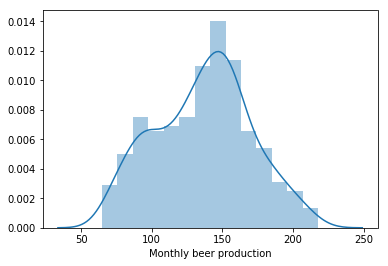

In [63]:
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql import Window
# Auxiliary functions
# Pandas Types -> Spark Types
#from edge.stats.sparksession import spark_session

def equivalent_type(f):
    if f == 'datetime64[ns]': return DateType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return DoubleType()
    else: return StringType()
def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)
# Converts pandas dataframe to spark dataframe
def pandas_to_spark(df_pandas):
    sqlContext = spark
    columns = list(df_pandas.columns)
    types = list(df_pandas.dtypes)
    struct_list = []
    for column, typo in zip(columns, types):
        struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(df_pandas, p_schema)

def densityplotdata(df, column):
    for i in df.columns:
        if i in column:
            s = df.select(i).dtypes[0]
            if s[1] == "int" or s[1] == "float" or s[1] == "double" or s[1] == "bigint" or s[1] == "long":
                temp_df=df.select(i).toPandas()
                for idx, var in enumerate(list(temp_df)):
                    myPlot = sns.distplot(temp_df[var])
                    lines2D = [obj for obj in myPlot.findobj() if str(type(obj)) == "<class 'matplotlib.lines.Line2D'>"]
                    x, y = lines2D[idx].get_data()[0], lines2D[idx].get_data()[1]
                    data=pd.DataFrame({'density_curve':y})
                temp_df=pandas_to_spark(data)
                return temp_df
                    
                
data=densityplotdata(df,'Monthly beer production') # to get curve data points
data.show()